<a href="https://colab.research.google.com/github/KimJisanER/medical_ai/blob/main/colab_autoregressive_simple_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch
!pip3 install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import math
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torchvision
import numpy as np 
import torchvision.transforms.functional as F_trans

from torch.nn import functional as F
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [3]:
"""
일반적인 Transformer를 정의하는데 필요한 모듈들을 정의한 공간입니다.
iGPT 전체 구조를 설명 드린 다음 자세한 내용을 소개드리도록 하겠습니다.
"""


class GELU(nn.Module):
    def __init__(self, use_approx=False):
        super().__init__()
        self.use_approx = use_approx

    def forward(self, x):
        if self.use_approx:
            # GELU 근사에 대한 조금 더 상세한 설명은 아래 링크를 보시면 좋을 것 같습니다.
            # iGPT 원래 코드는 근사 버전을 사용했는데 원래 버전을 사용해도 재현하는데 문제가 없었습니다. (iGPT-S 기준)
            # https://paperswithcode.com/method/gelu
            return x * torch.sigmoid(1.702 * x)  
        else:
            return F.gelu(x)


class MultiHeadSelfAttention(nn.Module):

    def __init__(self,
                 ctx_len: int,
                 embed_dim: int,
                 n_heads: int,
                 resid_pdrop: float,
                 attn_pdrop: float,
                 attn_bias: bool,
                 use_mask: bool = True):
        super().__init__()
        assert embed_dim % n_heads == 0

        # key, query, value projections for all heads
        self.key = nn.Linear(embed_dim, embed_dim, bias=attn_bias)
        self.query = nn.Linear(embed_dim, embed_dim, bias=attn_bias)
        self.value = nn.Linear(embed_dim, embed_dim, bias=attn_bias)

        # regularization
        self.attn_drop = nn.Dropout(attn_pdrop)
        self.resid_drop = nn.Dropout(resid_pdrop)

        # output projection
        self.proj = nn.Linear(embed_dim, embed_dim, attn_bias)

        self.n_heads = n_heads
        self.ctx_len = ctx_len
        self.use_mask = use_mask
        if self.use_mask:
            self.register_buffer("mask", torch.ones(ctx_len, ctx_len), persistent=False)
            self.mask = torch.tril(self.mask).view(1, ctx_len, ctx_len)

    def forward(self, x, use_cache=False, layer_past=None):
        B, T, C = x.shape
        x = x.transpose(0, 1).contiguous()  # (B, T, C) -> (T, B, C)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(T, B*self.n_heads, C//self.n_heads).transpose(0, 1)  # (B*nh, T, hs)
        q = self.query(x).view(T, B*self.n_heads, C//self.n_heads).transpose(0, 1)  # (B*nh, T, hs)
        v = self.value(x).view(T, B*self.n_heads, C//self.n_heads).transpose(0, 1)  # (B*nh, T, hs)

        if not use_cache:
            # Tensor shape below: (B * nh, T, hs) X (B * nh, hs, T) -> (B * nh, T, T)
            att = torch.bmm(q, (k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1))))
            if self.use_mask:
                mask = self.mask if T == self.ctx_len else self.mask[:, :T, :T]
                att = att.masked_fill(mask == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_drop(att)
            y = torch.bmm(att, v)  # (B*nh, T, T) X (B*nh, T, hs) -> (B*nh, T, hs)

            y = y.transpose(0, 1).contiguous().view(T, B, C)  # re-assemble all head outputs side by side
            # output projection
            y = self.resid_drop(self.proj(y))
            return y.transpose(0, 1).contiguous()  # (T, B, C) -> (B, T, C)
        else:
            present = torch.stack([k, v])

            if layer_past is not None:
                past_key, past_value = layer_past
                k = torch.cat([past_key, k], dim=-2)
                v = torch.cat([past_value, v], dim=-2)

                # Tensor shape below: (B * nh, 1, hs) X (B * nh, hs, K) -> (B * nh, 1, K)
                att = torch.bmm(q, (k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1))))
                att = F.softmax(att, dim=-1)
                att = self.attn_drop(att)
                y = torch.bmm(att, v)  # (B*nh, 1, K) X (B*nh, K, hs) -> (B*nh, 1, hs)
            else:
                att = torch.bmm(q, (k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1))))
                if self.use_mask:
                    mask = self.mask if T == self.ctx_len else self.mask[:, :T, :T]
                    att = att.masked_fill(mask == 0, float('-inf'))
                att = F.softmax(att, dim=-1)
                att = self.attn_drop(att)
                y = torch.bmm(att, v)  # (B*nh, T, T) X (B*nh, T, hs) -> (B*nh, T, hs)

            y = y.transpose(0, 1).contiguous().view(T, B, C)  # re-assemble all head outputs side by side
            # output projection
            y = self.resid_drop(self.proj(y))
            return y.transpose(0, 1).contiguous(), present  # (T, B, C) -> (B, T, C)


class Block(nn.Module):

    def __init__(self,
                 ctx_len: int,
                 embed_dim: int,
                 n_heads: int,
                 mlp_bias: bool,
                 attn_bias: bool,
                 resid_pdrop: bool,
                 attn_pdrop: bool,
                 gelu_use_approx: bool):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)

        self.attn = MultiHeadSelfAttention(ctx_len=ctx_len,
                                           embed_dim=embed_dim,
                                           n_heads=n_heads,
                                           attn_pdrop=attn_pdrop,
                                           resid_pdrop=resid_pdrop,
                                           attn_bias=attn_bias,
                                           use_mask=True)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim, bias=mlp_bias),
            GELU(gelu_use_approx),
            nn.Linear(4 * embed_dim, embed_dim, bias=mlp_bias),
            nn.Dropout(resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

    def sample(self, x, layer_past=None):
        attn, present = self.attn(self.ln1(x), use_cache=True, layer_past=layer_past)
        x = x + attn
        x = x + self.mlp(self.ln2(x))
        return x, present

In [4]:
class iGPT(nn.Module):
    """
    iGPT 클래스 선언 시에 arguments를 원래는 OmegaConf와 같은 config 인스턴스를 받는 것이 관리가 편한 것 같습니다. 
    하지만, 여기서는 편의를 위해 풀어서 받는 것으로 구현했습니다.
    """
    def __init__(self,
                 vocab_size_img: int,
                 ctx_len_img: int, 
                 embed_dim: int, 
                 n_heads: int, 
                 n_layers: int, 
                 mlp_bias: bool = True,
                 attn_bias: bool = True, 
                 embd_pdrop: float = 0.0,
                 resid_pdrop: float = 0.0,
                 attn_pdrop: float = 0.0,
                 gelu_use_approx: bool = False,
                 n_classes: Optional[int] = None) -> None:
        
        super().__init__()
        self.use_cls_cond = True if n_classes is not None else False

        # sos token embedding
        if self.use_cls_cond:
            self.sos = nn.Embedding(n_classes, embed_dim)
        else:
            self.sos = nn.Parameter(torch.randn(1, 1, embed_dim))

        # input embedding
        self.tok_emb_img = nn.Embedding(vocab_size_img, embed_dim)
        self.pos_emb_img = nn.Embedding(ctx_len_img, embed_dim)

        self.drop = nn.Dropout(embd_pdrop)

        # transformer blocks
        self.blocks = [Block(ctx_len=ctx_len_img + 1,
                             embed_dim=embed_dim,
                             n_heads=n_heads,
                             mlp_bias=mlp_bias,
                             attn_bias=attn_bias,
                             resid_pdrop=resid_pdrop,
                             attn_pdrop=attn_pdrop,
                             gelu_use_approx=gelu_use_approx) for i in range(1, n_layers+1)]
        self.blocks = nn.Sequential(*self.blocks)

        # head
        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size_img, bias=False)

        self.ctx_len_img = ctx_len_img
        self.n_layers = n_layers

        self.apply(self._init_weights)

    def _init_weights(self, module: nn.Module) -> None:
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    @torch.no_grad()
    def sampling(self,
                 sos: torch.FloatTensor,
                 codes: torch.LongTensor,
                 pos_codes: torch.LongTensor,
                 n_samples: int = 16,
                 past: Optional[torch.Tensor] = None) -> Tuple[torch.FloatTensor, List[torch.FloatTensor]]:
        
        # 캐싱된 결과를 사용하여 샘플링 하는 로직입니다.

        if codes is None:
            assert past is None
            xs = self.drop(sos)
            presents = []
            for i, block in enumerate(self.blocks):
                xs, present = block.sample(xs, layer_past=None)
                presents.append(present)
            xs = self.ln_f(xs)
            logits = self.head(xs)[:, -1]
        else:
            if past is None:
                xs = self.tok_emb_img(codes) + self.pos_emb_img(pos_codes)
                xs = torch.cat([sos, xs], dim=1)
            else:
                xs = self.tok_emb_img(codes) + self.pos_emb_img(pos_codes)
            xs = self.drop(xs)

            past = torch.cat(past, dim=-2) if past is not None else past
            presents = []
            for i, block in enumerate(self.blocks):
                xs, present = block.sample(xs, layer_past=None if past is None else past[i])
                presents.append(present)

            xs = self.ln_f(xs)
            logits = self.head(xs)[:, -1]
        return logits, presents

    def forward(self,
                codes: torch.LongTensor,
                labels: Optional[torch.LongTensor] = None) -> torch.FloatTensor:
        B, T = codes.shape
        xps = torch.arange(T, device=codes.device).repeat((B, 1))
        sos = self.sos.repeat((B, 1, 1)) if labels is None else self.sos(labels).unsqueeze(1)

        h = self.tok_emb_img(codes) + self.pos_emb_img(xps)
        h = torch.cat([sos, h[:, :-1]], dim=1).contiguous()

        h = self.drop(h)
        h = self.blocks(h)
        h = self.ln_f(h)
        logits = self.head(h)
        return logits

In [5]:
"""
Sampling을 위한 함수들 모음입니다.
"""

def cutoff_topk_logits(logits: torch.FloatTensor, k: int) -> torch.FloatTensor:
    if k is None:
        return logits
    else:
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        out[out < v[:, [-1]]] = -float('Inf')
        return out


def cutoff_topp_probs(probs: torch.FloatTensor, p: float) -> torch.FloatTensor:
    if p is None:
        return probs
    else:
        sorted_probs, sorted_indices = torch.sort(probs, dim=-1, descending=True)
        cum_probs = torch.cumsum(sorted_probs, dim=-1)

        sorted_idx_remove_cond = cum_probs >= p

        sorted_idx_remove_cond[..., 1:] = sorted_idx_remove_cond[..., :-1].clone()
        sorted_idx_remove_cond[..., 0] = 0

        indices_to_remove = sorted_idx_remove_cond.scatter(-1, sorted_indices, sorted_idx_remove_cond)
        probs = probs.masked_fill(indices_to_remove, 0.0)
        norm_probs = probs / torch.sum(probs, dim=-1, keepdim=True)
        return norm_probs


@torch.no_grad()
def sampling_igpt(model: torch.nn.Module,
                  sos: torch.FloatTensor,
                  top_k: Optional[float] = None,
                  top_p: Optional[float] = None,
                  softmax_temperature: float = 1.0,
                  is_tqdm: bool = True,
                  max_seq_len: int = 256) -> torch.LongTensor:
    code = None
    past = None
    pbar = tqdm(range(max_seq_len), total=max_seq_len) if is_tqdm else range(max_seq_len)

    for cnt, h in enumerate(pbar):
        if code is None:
            code_ = None
            pos_enc_code_ = None
        else:
            code_ = code.clone().detach()
            pos_enc_code_ = torch.arange(code_.shape[1], device=code_.device).repeat((code_.shape[0], 1))
            code_ = code_[:, cnt-1].unsqueeze(-1)
            pos_enc_code_ = pos_enc_code_[:, cnt-1].unsqueeze(-1)

        logits, present = model.sampling(sos=sos,
                                         codes=code_,
                                         pos_codes=pos_enc_code_,
                                         past=past)
        logits = logits.to(dtype=torch.float32)
        logits = logits / softmax_temperature

        present = torch.stack(present).clone().detach()
        if past is None:
            past = [present]
        else:
            past.append(present)

        logits = cutoff_topk_logits(logits, top_k)
        probs = F.softmax(logits, dim=-1)
        probs = cutoff_topp_probs(probs, top_p)

        idx = torch.multinomial(probs, num_samples=1).clone().detach()
        code = idx if code is None else torch.cat([code, idx], axis=1)

    del past
    return code

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

60000 10000


tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   7,  27,  91, 143,
        164, 205, 206, 181, 234,  76,   0,   0,   0,   0,   0,   0, 109, 253,
        253, 253, 230, 250,  81,  51,  31,   0,   0,   0,   0,   0,   0,   0,
         26, 132, 222, 214,   6,  49,  16,   0,   0,   0,   0,   0,   0,   0,
          0,   0])

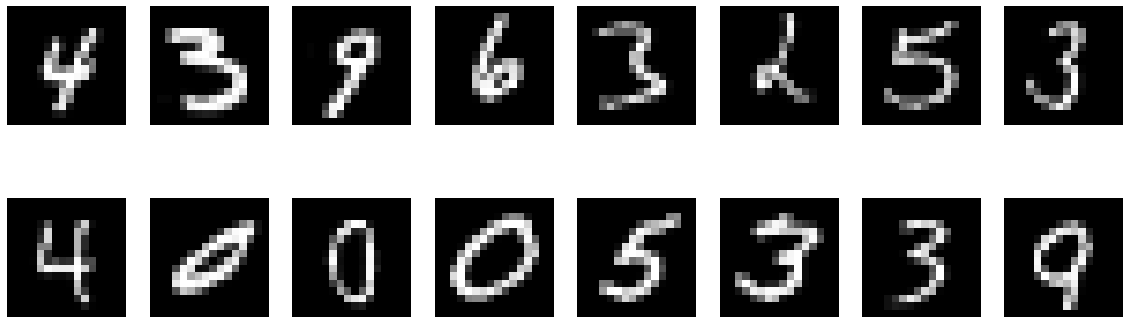

In [6]:
HEIGHT, WIDTH = 16, 16

class ImageDataset(Dataset):
    """
    실습을 위한 ImageDataset입니다. MNIST와 같은 28x28 gray-scale image를 784-dimensional 1D tensor로 변환해줍니다.
    """
    
    def __init__(self, pt_dataset, H=28, W=28):
        self.pt_dataset = pt_dataset
        self.height = H
        self.width = W
        self.block_size = H*W - 1
        self.vocab_size = 256  # 8bit-gray
        
    def __len__(self):
        return len(self.pt_dataset)

    def __getitem__(self, idx: int) -> Tuple[torch.LongTensor, torch.LongTensor, torch.LongTensor]:
        x, y = self.pt_dataset[idx]
        x = (x.view(-1) * 255).to(dtype=torch.int64)
        return x[:-1], x[1:], y # always just predict the next one in the sequence


# train / valid dataset
train_data = torchvision.datasets.MNIST('./data', train=True, download=True, 
                                        transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((HEIGHT, WIDTH))]))
valid_data = torchvision.datasets.MNIST('./data', train=False, download=True,
                                        transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((HEIGHT, WIDTH))]))

print(len(train_data), len(valid_data))

# encode the training examples with our codebook to visualize how much we've lost in the discretization
n_samples = 16
ncol = 8
nrow = n_samples // ncol + 1
plt.figure(figsize=(20, 10))
for i in range(n_samples):
    # encode and decode random data
    x, y = train_data[np.random.randint(0, len(train_data))]
    x = torch.from_numpy(np.array(x))
    # these images should look normal ideally
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(x.view(HEIGHT, WIDTH).numpy(), cmap='gray')
    plt.axis('off')

train_dataset = ImageDataset(train_data, H=HEIGHT, W=WIDTH)
valid_dataset = ImageDataset(valid_data, H=HEIGHT, W=WIDTH)
train_dataset[0][0][:100] # one example image flattened out into integers

In [7]:
from torch.optim.lr_scheduler import CosineAnnealingLR

config = {}
config['local_batch_size'] = 128
config['total_batch_size'] = 256
config['valid_batch_size'] = 64
config['epochs'] = 3
config['lr'] = 1e-4
config['lr_min'] = 1e-4
config['betas'] = (0.9, 0.95)
config['weight_decay'] = 0.0

'''
model = iGPT(vocab_size_img=256, 
             ctx_len_img=HEIGHT*WIDTH-1, 
             embed_dim=256, 
             n_heads=8, 
             n_layers=4,
             n_classes=None)
'''
model = iGPT(vocab_size_img=256, 
             ctx_len_img=HEIGHT*WIDTH-1, 
             embed_dim=256, 
             n_heads=8, 
             n_layers=4,
             n_classes=10)
model.cuda()

accum_steps = config['total_batch_size'] // config['local_batch_size']
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['local_batch_size'], shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config['local_batch_size'], shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=config['lr'],
                              betas=config['betas'],
                              weight_decay=config['weight_decay'])
scheduler = CosineAnnealingLR(optimizer,
                              T_max=config['epochs'] * len(train_loader),
                              eta_min=config['lr_min'])

def train(epoch):
    model.train()
    model.zero_grad()
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for it, (xs, ys, labels) in pbar:
        xs = xs.cuda()
        ys = ys.cuda()
        labels = labels.cuda()
        # logits = model(xs)
        logits = model(xs, labels)
        loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), ys.view(-1))
        loss.backward()
        if (it + 1) % accum_steps == 0:
            optimizer.step()
            scheduler.step()
            model.zero_grad()
            pbar.set_description(f"""Train, epoch {epoch+1} iter {it}: train loss {loss.item():.4f}, lr {scheduler.get_last_lr()[0]:e}""")


@torch.no_grad()
def valid(epoch):
    model.eval()
    valid_loss = 0
    n_samples = 0
    pbar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    for it, (xs, ys, labels) in pbar:
        xs = xs.cuda()
        ys = ys.cuda()
        labels = labels.cuda()
        # logits = model(xs)
        logits = model(xs, labels)
        loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), ys.view(-1))
        valid_loss += loss.item() * xs.shape[0]
        n_samples += xs.shape[0]
        pbar.set_description(f"""Valid, epoch {epoch+1} iter {it}: train loss {loss.item():.4f}, lr {scheduler.get_last_lr()[0]:e}""")
    print(f'\nValid: Average loss: {valid_loss / n_samples:.4f}')


# 학습 및 평가
for ep in range(config['epochs']):
    train(ep)
    valid(ep)

Train, epoch 1 iter 467: train loss 1.5983, lr 1.000000e-04: 100%|██████████| 469/469 [02:49<00:00,  2.77it/s]
Valid, epoch 1 iter 78: train loss 1.6407, lr 1.000000e-04: 100%|██████████| 79/79 [00:11<00:00,  6.92it/s]



Valid: Average loss: 1.6099


Train, epoch 2 iter 467: train loss 1.4848, lr 1.000000e-04: 100%|██████████| 469/469 [02:56<00:00,  2.66it/s]
Valid, epoch 2 iter 78: train loss 1.4323, lr 1.000000e-04: 100%|██████████| 79/79 [00:11<00:00,  6.80it/s]



Valid: Average loss: 1.4441


Train, epoch 3 iter 467: train loss 1.3576, lr 1.000000e-04: 100%|██████████| 469/469 [02:56<00:00,  2.66it/s]
Valid, epoch 3 iter 78: train loss 1.3656, lr 1.000000e-04: 100%|██████████| 79/79 [00:11<00:00,  6.85it/s]


Valid: Average loss: 1.3772


100%|██████████| 256/256 [00:01<00:00, 233.93it/s]


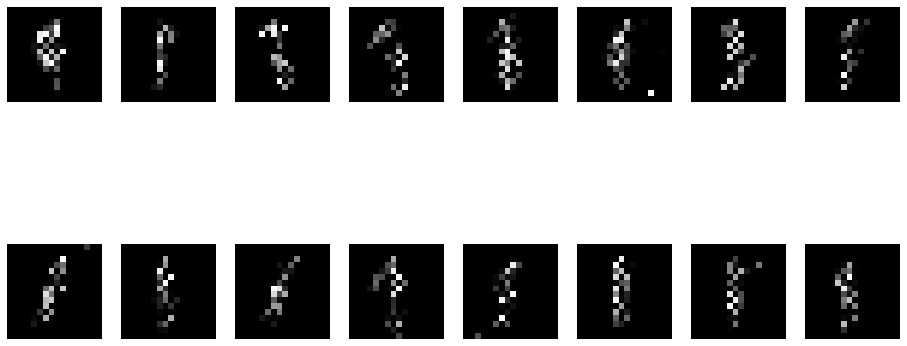

In [8]:
N_SAMPLES = 16

# sos = model.sos.repeat(N_SAMPLES, 1, 1)
sos = model.sos(torch.LongTensor([1]).repeat(N_SAMPLES, 1).cuda())
codes = sampling_igpt(model,
                      sos=sos,
                      top_k=256,
                      top_p=1.0,
                      softmax_temperature=1.0,
                      max_seq_len=HEIGHT*WIDTH)
codes = codes.view(N_SAMPLES, HEIGHT*WIDTH)

ncol = 8
nrow = N_SAMPLES // ncol
plt.figure(figsize=(16, 8))
for i in range(N_SAMPLES):
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(codes[i].view(HEIGHT, WIDTH).cpu().numpy().astype(np.uint8), cmap='gray')
    plt.axis('off')